# *clone2vec* simple tutorial

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sclitr as sl

sc.set_figure_params(dpi=80)
sns.set_style("ticks")

Firstly, let's take a look at the dataset.

In [2]:
adata = sl.datasets.Weinreb_in_vitro()

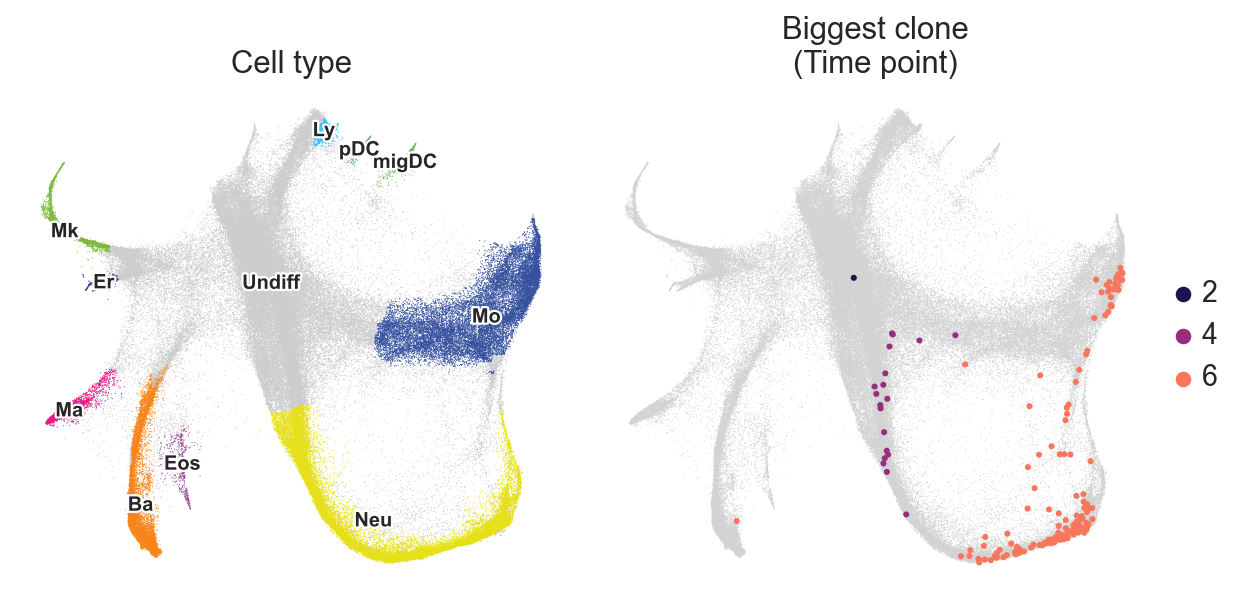

In [3]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

sc.pl.embedding(
    adata,
    basis="X_spring",
    color="Cell type annotation short",
    frameon=False,
    title="Cell type",
    legend_loc="on data",
    legend_fontsize=9,
    legend_fontoutline=2,
    ax=axes[0],
    show=False,
)

sl.pl.clone(
    adata,
    clone_col="Clone",
    clone_name=adata.obs["Clone"].value_counts().index[1],
    basis="X_spring",
    title="Biggest clone",
    kwargs_clone={"color": "Time point"},
    ax=axes[1],
)

fig.tight_layout()

Secondly, let's explore the distribution of clone sizes.

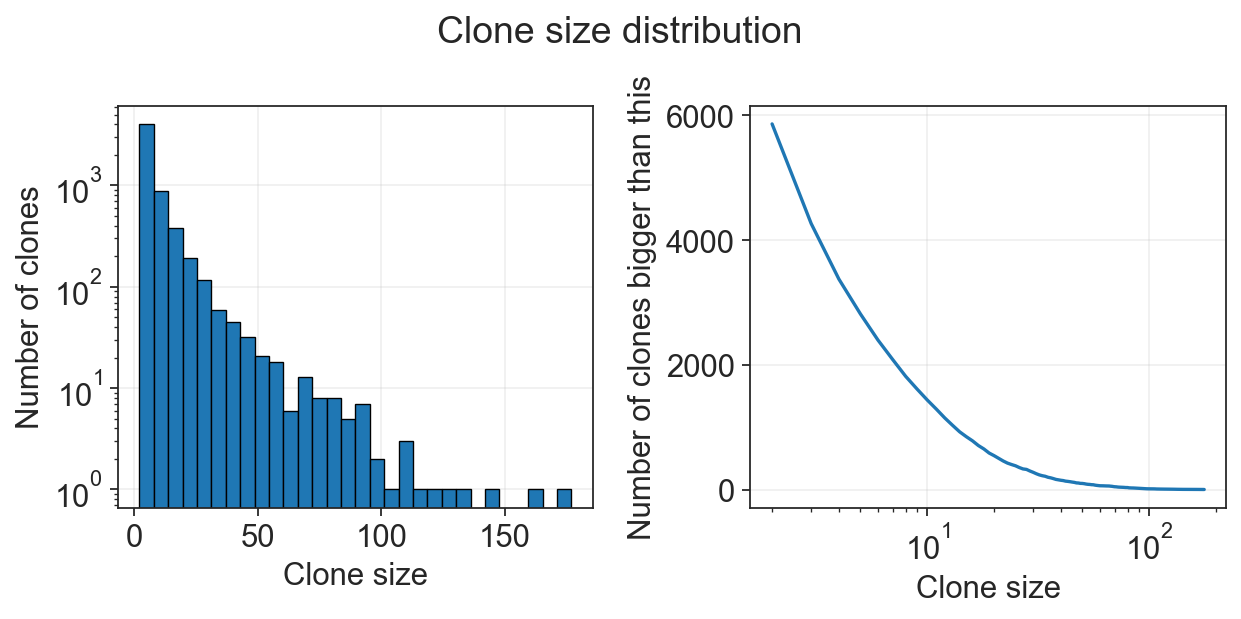

In [4]:
sl.pl.basic_stats(adata, obs_name="Clone", title="Clone size distribution")

Now, let's find clonally labeled nearest neighbours for each cell.

In [5]:
sl.tl.clonal_nn(
    adata,
    obs_name="Clone",
    use_rep="X_pca_harmony",
    min_size=5,
    tqdm_bar=True,
)

100%|██████████| 130887/130887 [02:07<00:00, 1026.46it/s]


Now we have sparce matrix matrix with number of each clone in *k* (default `k = 15`) nearest neighbours for each cell in `adata.obsm["bag-of-clones"]` and clone names in `adata.uns["bag-of-clones_names"]`.

In [6]:
clones = sl.tl.clone2vec(
    adata,
    obs_name="Clone",
    fill_ct="Cell type annotation short",
    device="cuda:0",
    n_epochs=100,
)

100%|██████████| 100/100 [25:53<00:00, 15.53s/it]
/home/sergey/tools/scLiTr/sclitr/tl.py:616: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_counts = adata_only_clones.obs.groupby(


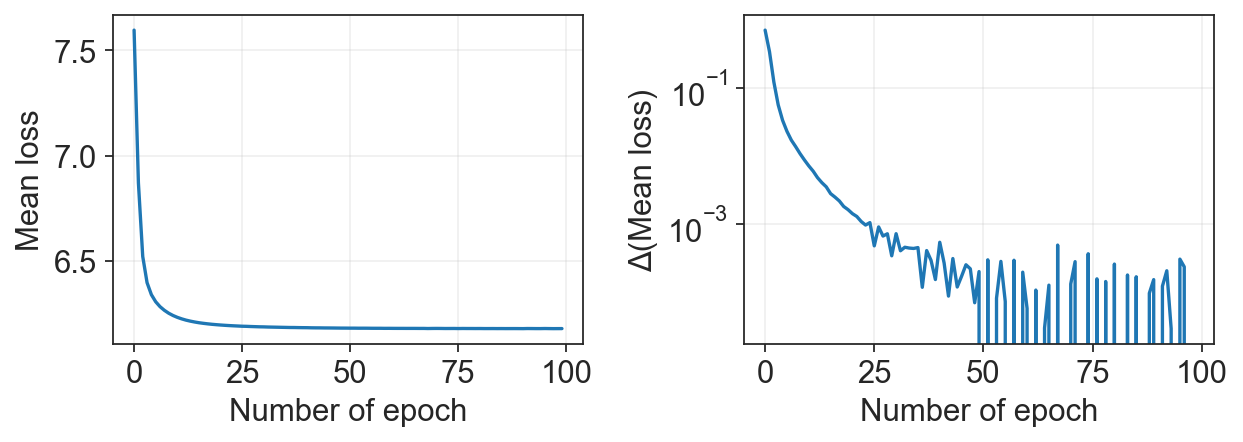

In [7]:
sl.pl.epochs_loss(clones)

Now, let's construct kNN-graph and UMAP based on latent representation of the clones.

In [8]:
sc.pp.neighbors(clones, use_rep="clone2vec", n_neighbors=15)
sc.tl.umap(clones)

2025-05-02 13:58:53.125102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-02 13:58:53.222254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-02 13:58:53.249907: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-02 13:58:53.406472: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-02 13:58:54.930831: W tensorflow/compiler/tf2

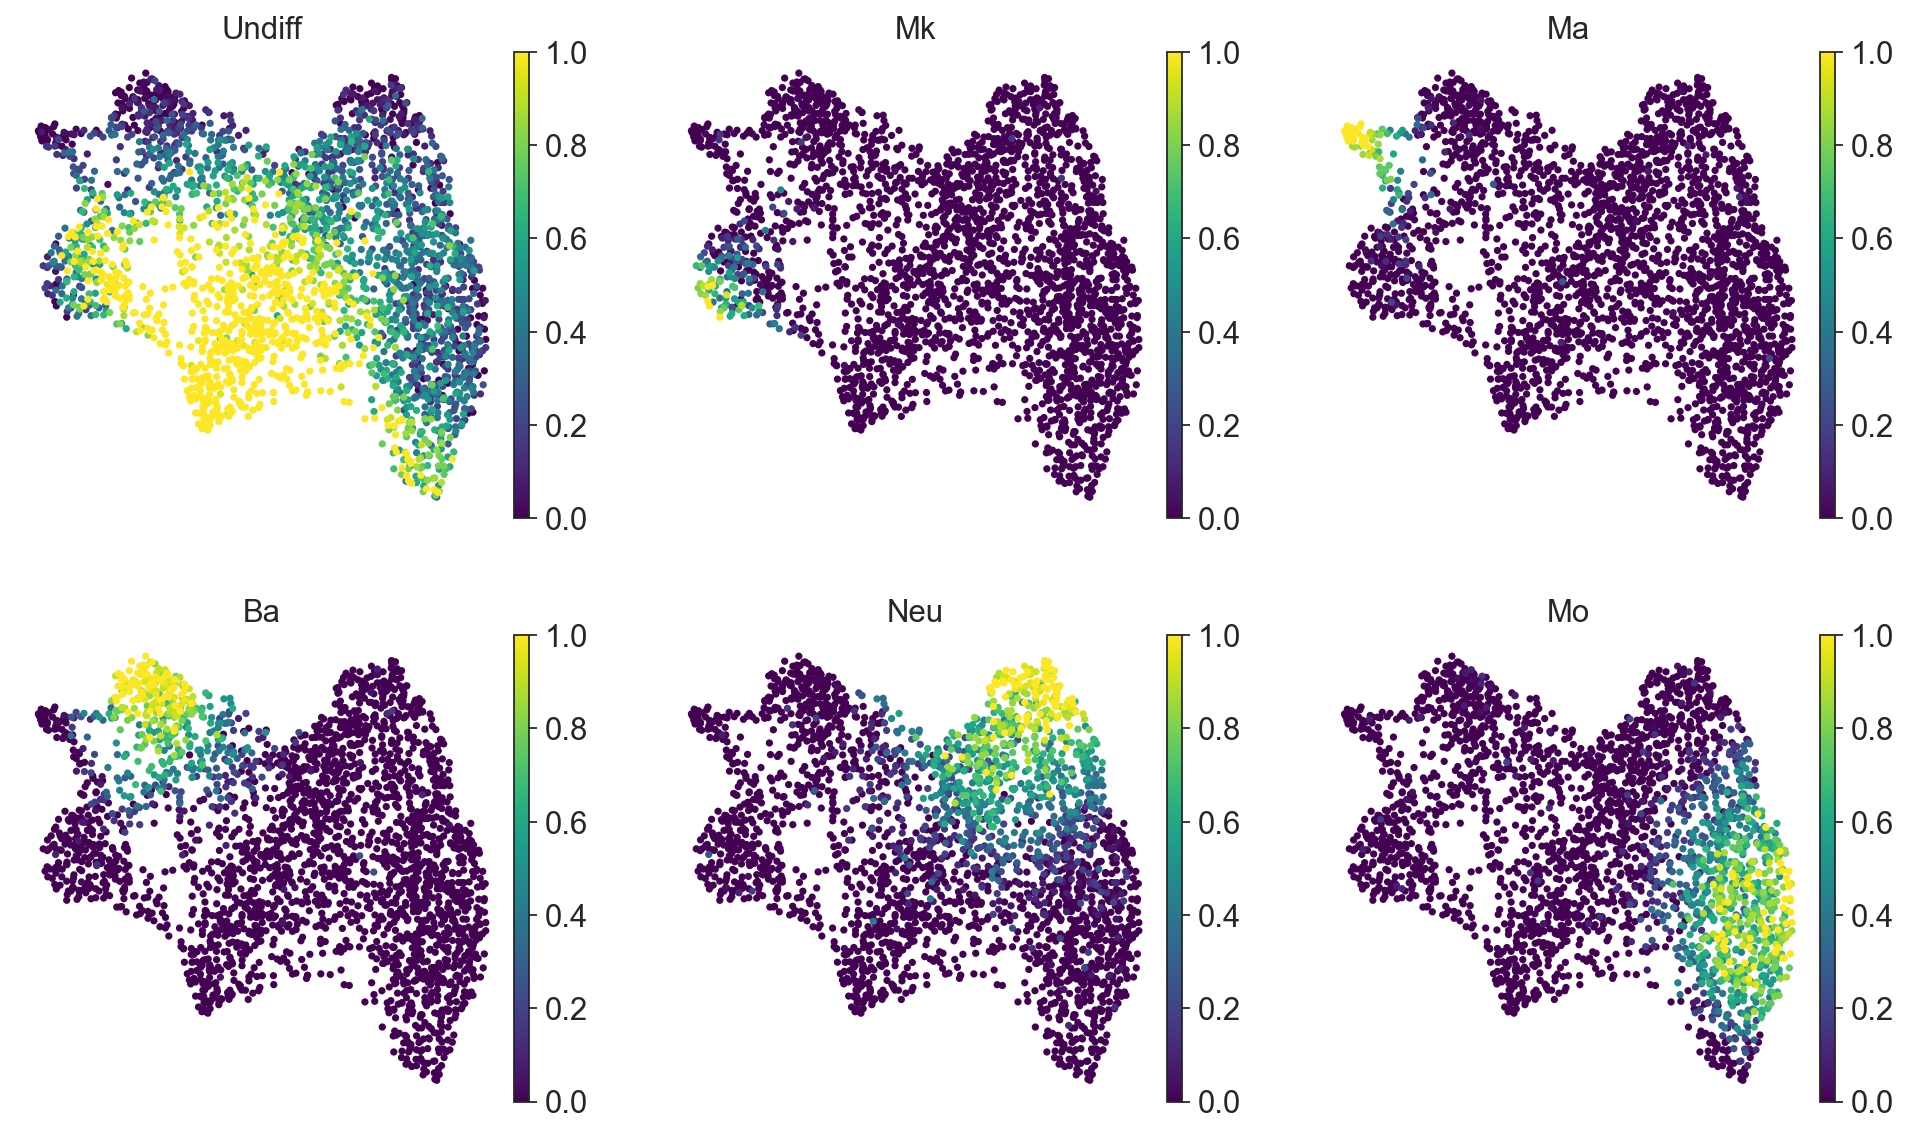

In [9]:
sc.pl.umap(
    clones,
    color=["Undiff", "Mk", "Ma", "Ba", "Neu", "Mo"],
    layer="frequencies",
    frameon=False,
    cmap="viridis",
    ncols=3,
)

And finally let's construct clustering and define mixed clonal cluster:

/tmp/ipykernel_2573/3702231428.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(clones, resolution=1)


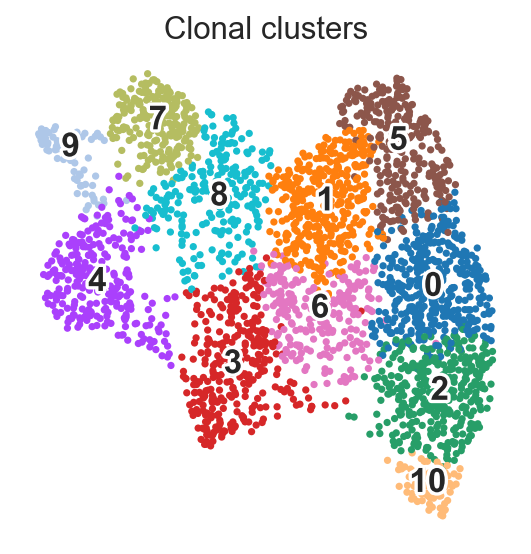

In [10]:
sc.tl.leiden(clones, resolution=1)

sc.pl.umap(
    clones,
    color="leiden",
    frameon=False,
    title="Clonal clusters",
    legend_loc="on data",
    legend_fontsize=15,
    legend_fontoutline=3
)

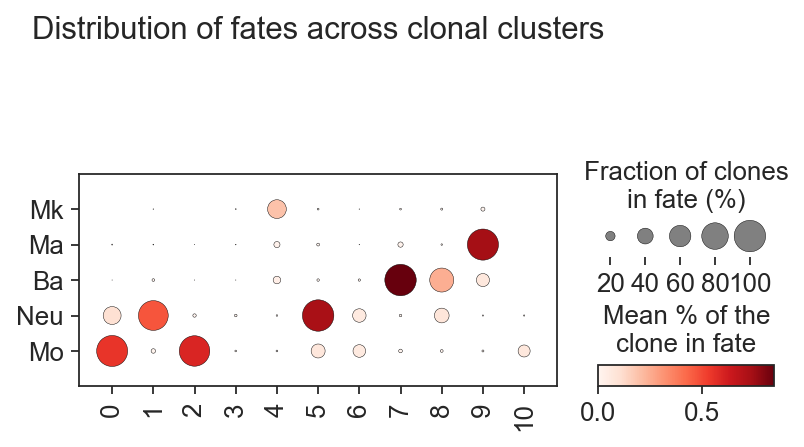

In [11]:
sc.pl.dotplot(
    clones,
    var_names=["Mk", "Ma", "Ba", "Neu", "Mo"],
    groupby="leiden",
    layer="frequencies",
    colorbar_title="Mean % of the\nclone in fate",
    cmap="Reds",
    swap_axes=True,
    size_title="Fraction of clones\nin fate (%)",
    title="Distribution of fates across clonal clusters",
    dot_max=1,
)

And now we can map it back onto the cells' manifold.

In [12]:
sl.tl.transfer_clonal_annotation(
    adata,
    clones,
    adata_clone_name="Clone",
    adata_obs_name="Clonal cluster",
    clones_obs_name="leiden",
    fill_values="NA",
)

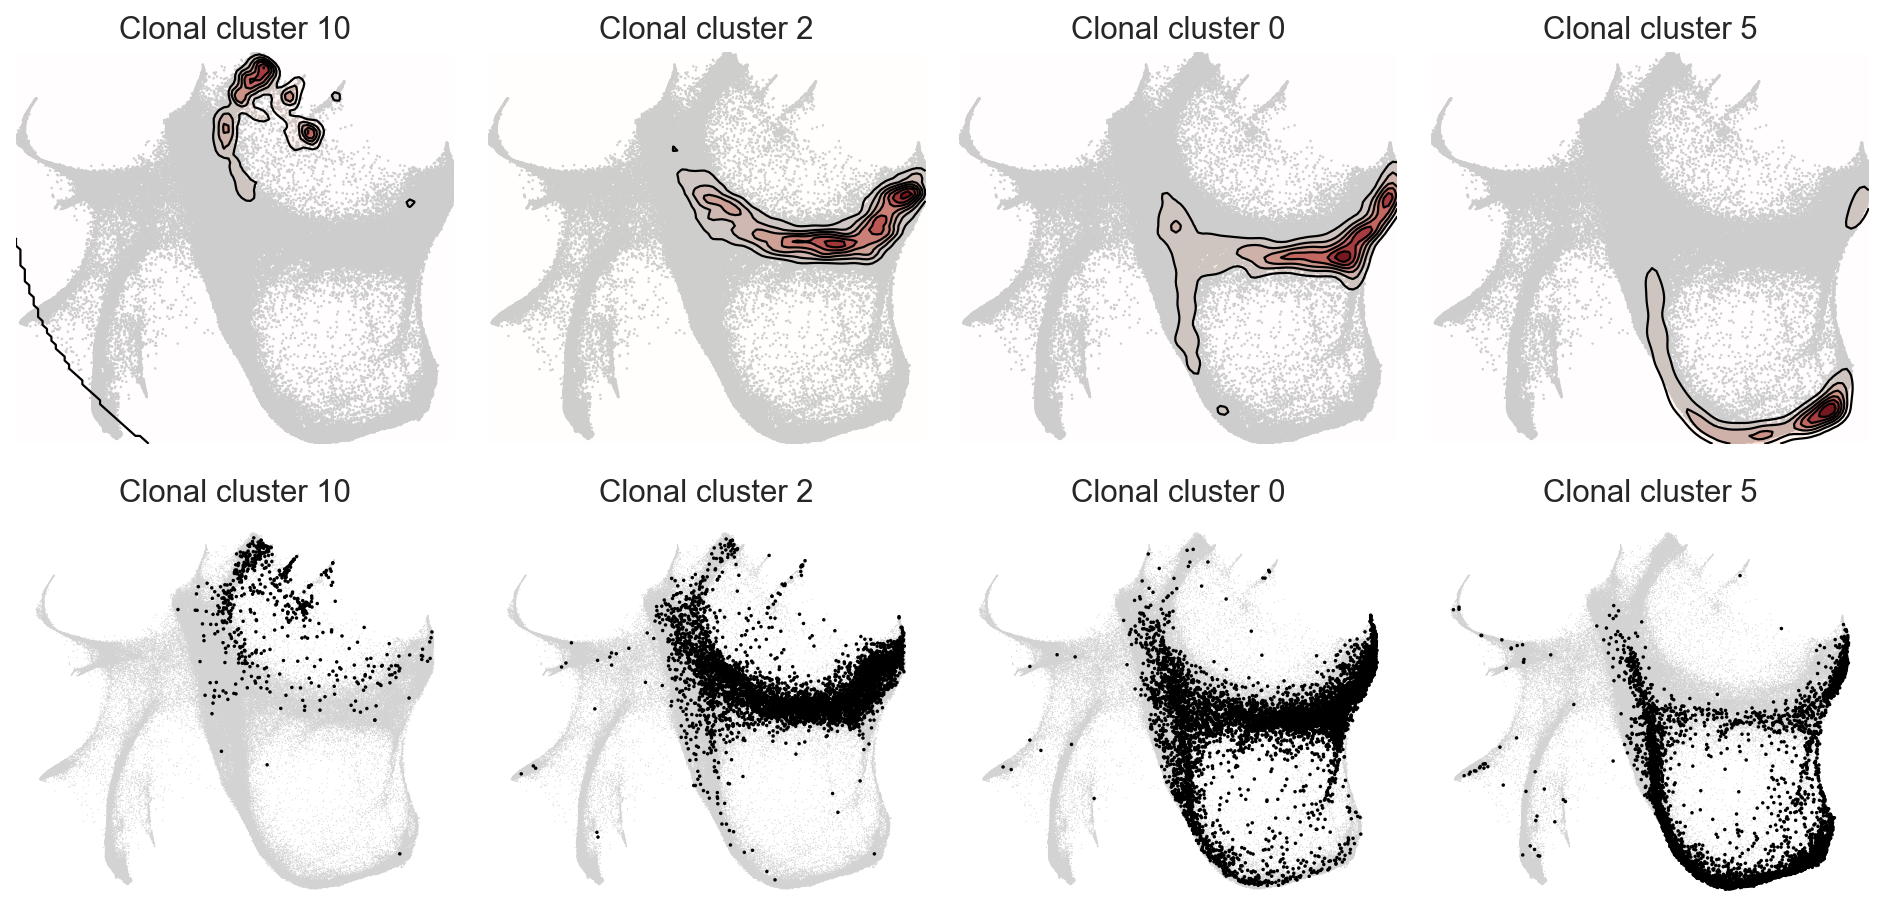

In [14]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(12, 6))

for i, clonal_cluster in enumerate(["10", "2", "0", "5"]):
    sl.pl.kde(
        adata,
        basis="X_spring",
        groupby="Clonal cluster",
        group=clonal_cluster,
        title=f"Clonal cluster {clonal_cluster}",
        ax=axes[0, i],
    )

    sl.pl.clone(
        adata,
        clone_col="Clonal cluster",
        clone_name=clonal_cluster,
        basis="X_spring",
        title=f"Clonal cluster {clonal_cluster}",
        s=10,
        ax=axes[1, i],
    )
    
fig.tight_layout()

In [15]:
adata.write_h5ad("Weinreb_GEX.h5ad")
clones.write_h5ad("Weinreb_clones.h5ad")

And finally we can prepare clones2cells-friendly csv-files.

In [16]:
df_gex = sl.pp.prepare_clones2cells(
    adata,
    embedding_type="GEX",
    clonal_obs="Clone",
    keep_obs=["Time point", "Cell type annotation"],
    dimred_name="X_spring",
)

df_clones = sl.pp.prepare_clones2cells(
    clones,
    embedding_type="clone2vec",
    keep_obs=["leiden"],
)

df_gex.to_csv("GEX.csv")
df_clones.to_csv("clone2vec.csv")